You’re optimising a cake recipe using a black-box function with five ingredient inputs, for example flour, sugar, eggs, butter and milk. Each recipe is evaluated with a combined score based on flavour, consistency, calories, waste and cost, where each factor contributes negative points as judged by an expert taster. This means the total score is negative by design. 

To frame this as a maximisation problem, your goal is to bring that score as close to zero as possible or, equivalently, to maximise the negative of the total sum.

In [2]:
import numpy as np
import pandas as pd

In [4]:
inputs_f6 = np.load('function_6/initial_inputs.npy')
outputs_f6 = np.load('function_6/initial_outputs.npy')

In [5]:
print("Inputs (Function 6):", inputs_f6)

Inputs (Function 6): [[0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
 [0.24238435 0.84409997 0.5778091  0.67902128 0.50195289]
 [0.72952261 0.7481062  0.67977464 0.35655228 0.67105368]
 [0.77062024 0.11440374 0.04677993 0.64832428 0.27354905]
 [0.6188123  0.33180214 0.18728787 0.75623847 0.3288348 ]
 [0.78495809 0.91068235 0.7081201  0.95922543 0.0049115 ]
 [0.14511079 0.8966846  0.89632223 0.72627154 0.23627199]
 [0.94506907 0.28845905 0.97880576 0.96165559 0.59801594]
 [0.12572016 0.86272469 0.02854433 0.24660527 0.75120624]
 [0.75759436 0.35583141 0.0165229  0.4342072  0.11243304]
 [0.5367969  0.30878091 0.41187929 0.38822518 0.5225283 ]
 [0.95773967 0.23566857 0.09914585 0.15680593 0.07131737]
 [0.6293079  0.80348368 0.81140844 0.04561319 0.11062446]
 [0.02173531 0.42808424 0.83593944 0.48948866 0.51108173]
 [0.43934426 0.69892383 0.42682022 0.10947609 0.87788847]
 [0.25890557 0.79367771 0.6421139  0.19667346 0.59310318]
 [0.43216593 0.71561781 0.3418191  0.70499988 0.614

In [6]:
print("Outputs (Function 6):", outputs_f6)

Outputs (Function 6): [-0.71426495 -1.20995524 -1.67219994 -1.53605771 -0.82923655 -1.24704893
 -1.23378638 -1.69434344 -2.57116963 -1.30911635 -1.14478485 -1.91267714
 -1.62283895 -1.35668211 -2.0184254  -1.70255784 -1.29424696 -0.93575656
 -2.15576776 -1.74688209]


Best value 

In [7]:

idx_best = np.argmax(outputs_f6)
x_best = inputs_f6[idx_best]
y_best = outputs_f6[idx_best]

print("Best hyperparameter combination:", x_best)
print("Best output:", y_best)

Best hyperparameter combination: [0.7281861  0.15469257 0.73255167 0.69399651 0.05640131]
Best output: -0.7142649478202404


Visualtize the plots 

Shows 2D projections of hyperparameters

Color = output value

Helps visually identify regions of high output

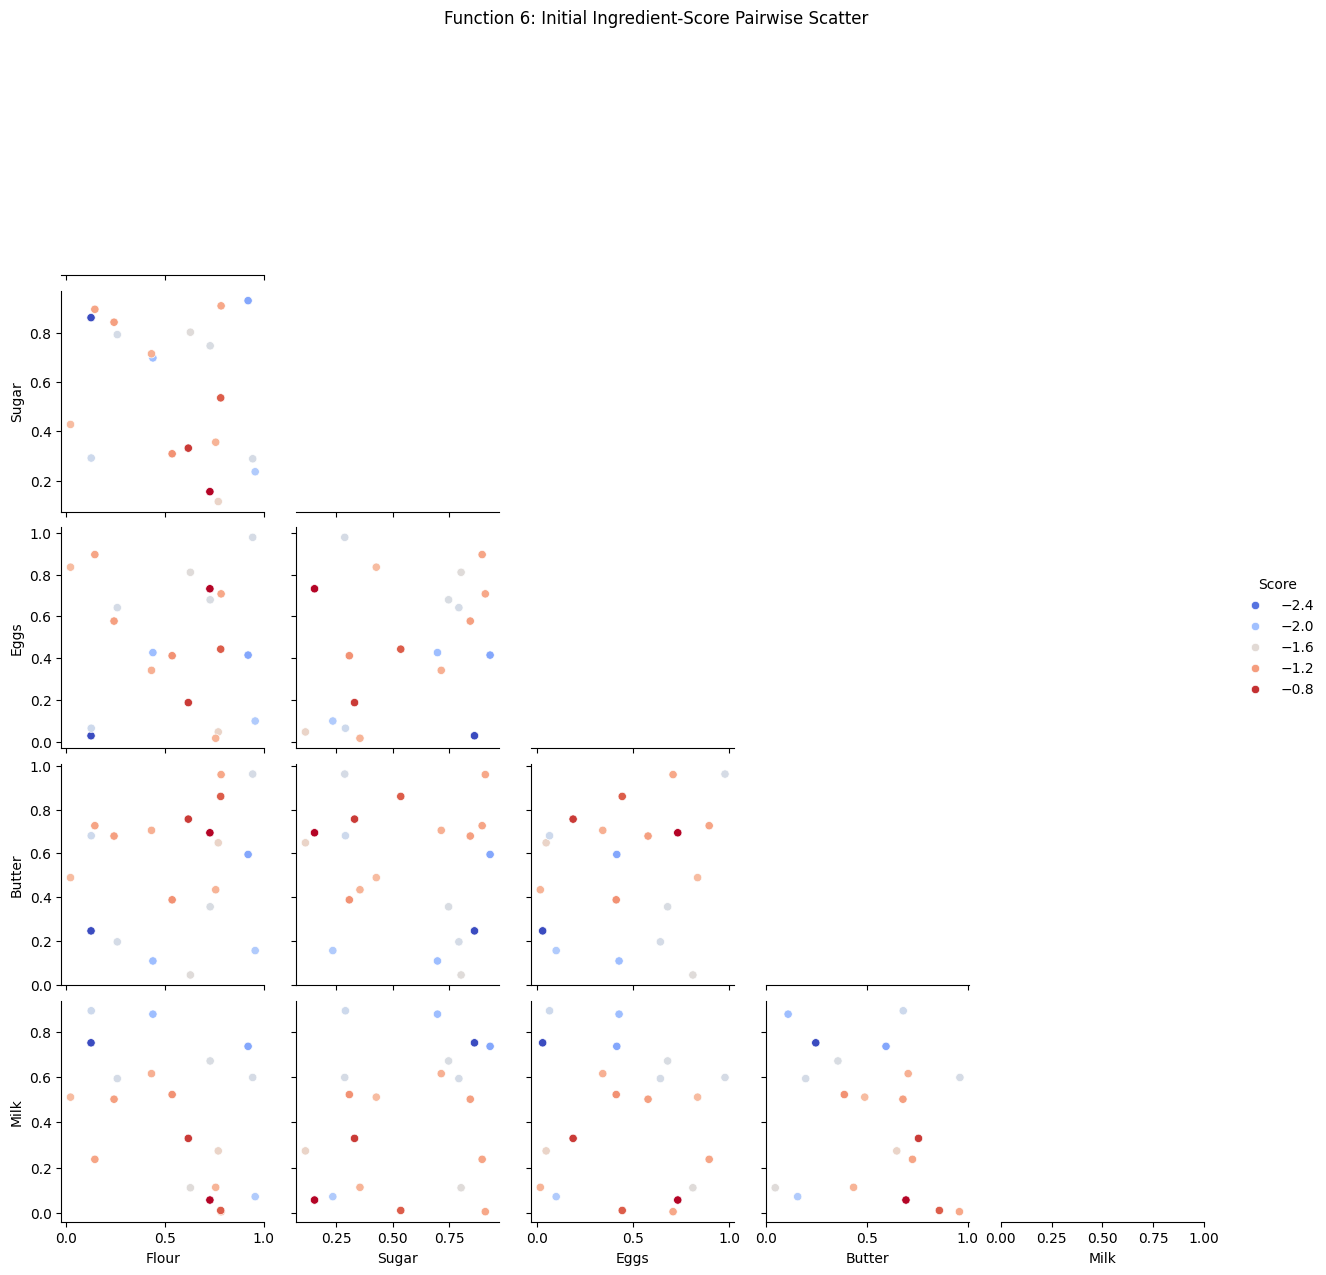

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1b. Pairwise scatter plots for 5D (corner=True limits redundant plots)
df = pd.DataFrame(inputs_f6, columns=['Flour','Sugar','Eggs','Butter','Milk'])
df['Score'] = outputs_f6

sns.pairplot(df, hue='Score', palette='coolwarm', corner=True)
plt.suptitle('Function 6: Initial Ingredient-Score Pairwise Scatter', y=1.02)
plt.show()

Fit the gaussian process

In [9]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel

# 2a. Kernel for smooth + noisy outputs
kernel = 1.0 * RBF(length_scale=0.2, length_scale_bounds=(1e-2,1.0)) \
         + WhiteKernel(noise_level=1e-2, noise_level_bounds=(1e-6,1.0))


In [ ]:
# 2b. Fit GP
gp_f6 = GaussianProcessRegressor(
    kernel=kernel,
    normalize_y=True,
    n_restarts_optimizer=10,
    random_state=42
)

gp_f6.fit(inputs_f6, outputs_f6)
print("Optimized kernel:", gp_f6.kernel_) #✅ Now gp_f6 is a surrogate model predicting your score for any recipe.

Optimized kernel: 1.13**2 * RBF(length_scale=0.509) + WhiteKernel(noise_level=0.0252)


Step 3: Suggest the next point using UCB

Goal: maximize output (less negative)

In [11]:
# 3a. Sample candidate recipes in 5D
num_candidates = 20000  # more candidates to explore the space
X_candidates = np.random.rand(num_candidates, 5)

# 3b. GP prediction: mean and uncertainty
mu, sigma = gp_f6.predict(X_candidates, return_std=True)

# 3c. UCB acquisition function
kappa = 5.0  # high = more exploration
UCB = mu + kappa * sigma

# 3d. Next suggested recipe
idx_next = np.argmax(UCB)
x_next = X_candidates[idx_next]

print("Next recipe suggested by BO (exploration-focused):", x_next)

Next recipe suggested by BO (exploration-focused): [0.03804571 0.11049267 0.44652176 0.95927725 0.02023971]


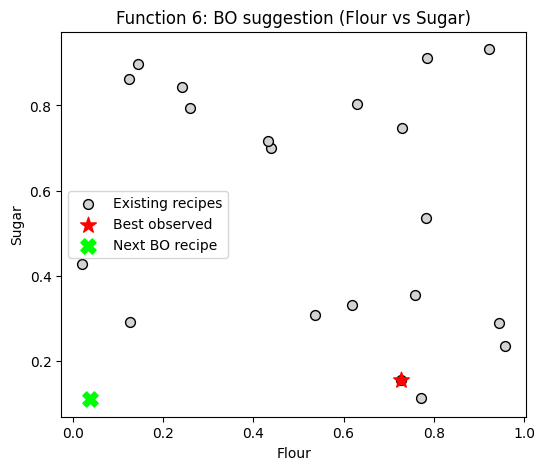

In [12]:
# Example: Flour vs Sugar
plt.figure(figsize=(6,5))
plt.scatter(inputs_f6[:,0], inputs_f6[:,1], c='lightgray', s=50, edgecolors='black', label='Existing recipes')
plt.scatter(x_best[0], x_best[1], c='red', s=140, marker='*', label='Best observed')
plt.scatter(x_next[0], x_next[1], c='lime', s=120, marker='X', label='Next BO recipe')
plt.xlabel('Flour')
plt.ylabel('Sugar')
plt.title('Function 6: BO suggestion (Flour vs Sugar)')
plt.legend()
plt.show()